# Praca domowa z ML numer 6

<a href="https://colab.research.google.com/github/tomczj/ML24_25/blob/main/Tree_Methods/homework_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Oznaczenia:
$R_m(X_j, t)$ <- region powstały po podzieleniu aktualnego liścia względem cechy $X_j$ przy poziomie $t$ (nowe liście)\
$\bar{y}_{R_m}$ <- średnia wartość zmiennej wynikowej w regionie $R_m$\
$T$ <- aktualne drzewo\
$T(X_j, t)$ <- drzewo, które powstało z T po dodaniu dwóch nowych liści $R_1(X_j, t)$, $R_2(X_j, t)$\
$\mathrm{Leaves}(T(X_j, t))$ <- zbiór wszystkich możliwych liści w drzewie $T(X_j, t)$

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Słowem wstępu...

Celem tej pracy domowej jest opisanie wybranych podejść do wyznaczania cech i ich poziomów rozdzielenia przy budowaniu drzewa decyzyjnego. Będziemy chcieli sprawdzić trzy metody:

1. **Lokalna minimalizacja**  
   błędu średniokwadratowego dla różnych wartości $t$ oraz różnych cech $X_j$. Innymi słowy, w kolejnych krokach budowania drzewa będziemy chcieli znaleźć taką parę $(X_j^*, t^*)$, aby przy podziale kolejnych liści zachodziło
   $$
   (X_j^*, t^*) = \arg\min_{X_j, t} \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2.
   $$
   Takie podejście stosujemy dla każdego kolejnego liścia, co oznacza, że (jak sama nazwa wskazuje) jest to metoda lokalna – w danym momencie analizujemy tylko jednego rodzica i dwa nowe liście.

2. **Maksymalizacja przyrostu**  
   błędu średniokwadratowego również stanowi metodę lokalną, której idea polega na wybraniu pary $(X_j^*, t^*)$ tak, aby zmaksymalizować redukcję błędu po dodaniu nowych liści. Innymi słowy, wyznaczamy
   $$
   (X_j^*, t^*) = \arg\max_{X_j, t} \Bigl\{
   \underbrace{\sum_{i : x_i \in \text{Rodzic}} (y_i - \bar{y})^2}_{\text{Błąd średniokwadratowy u rodzica}}
   \;-\;
   \underbrace{\sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2}_{\text{Błąd średniokwadratowy w nowych liściach}}
   \Bigr\}
   $$
   po dodaniu do aktualnego liścia dwóch nowych.

3. **Minimalizacja całości**  
   błędu średniokwadratowego. Jest to podejście bardziej złożone i – w przeciwieństwie do dwóch poprzednich – **nie jest metodą lokalną w sensie ścisłym** (choć w pewnym ograniczonym sensie można ją tak traktować). W danym momencie patrzymy na jeden wybrany liść drzewa $T$ i dzielimy go na dwa regiony $R_1(X_j, t)$ oraz $R_2(X_j, t)$. Następnie analizujemy, jak wygląda błąd średniokwadratowy w całym drzewie $T(X_j, t)$, ale w podziale na poszczególne regiony. Innymi słowy, szukamy
   $$
   (X_j^*, t^*) = \arg\min_{(X_j, t)} \sum_{m \in \mathrm{Leaves}(T(X_j, t))} \sum_{i \in R_m} \Bigl(y_i - \overline{y}_{R_m}\Bigr)^2.
   $$
   Jest to poprawnie zdefiniowane zadanie, ponieważ wszystkie możliwe liście (regiony) $R_m$ stanowią rozbicie przestrzeni wejściowej na rozłączne obszary.




# Równoważność poszczególnych podejść

Można się zastanowić, czy pomiędzy powyższymi podejściami istnieją równoważności. Innymi słowy: czy różne metody prowadzą do tych samych wyników? W szczególności – zgodnie z treścią zadania – przyjrzymy się, czy **metoda 1** prowadzi do takich samych wyników, co **metoda 2**.

Wystarczy zestawić matematyczne formuły. W metodzie 1 jesteśmy w danym liściu, dzielimy go na dwa względem cech i progów, i szukamy pary $(X_j, t)$, która minimalizuje błąd średniokwadratowy:

$$
   (X_j^*, t^*) = \arg\min_{X_j, t} \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2.
$$

Korzystając z poniższych przekształceń (pierwsza suma jest stała z perspektywy aktualnie dzielonego liścia), mamy:

\begin{align*}
\max_{X_j, t} \Bigl\{
   \sum_{i : x_i \in \text{Rodzic}} (y_i - \bar{y})^2
   \;-\;
   \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2 
   \Bigr\} &= \sum_{i : x_i \in \text{Rodzic}} (y_i - \bar{y})^2
   \;+\ \max_{X_j, t} \Bigl\{ -
   \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2 
   \Bigr\}\\
    &= \sum_{i : x_i \in \text{Rodzic}} (y_i - \bar{y})^2
   \;-\ \min_{X_j, t} \Bigl\{
   \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2 
   \Bigr\}.
\end{align*}

Wobec tego:

$$
\arg\min_{X_j, t} \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2 = \arg\max_{X_j, t} \Bigl\{
   \sum_{i : x_i \in \text{Rodzic}} (y_i - \bar{y})^2
   \;-\;
   \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2
   \Bigr\},
$$

czyli **podejście 1 jest równoważne podejściu 2**.


# A jak to wygląda w przypadku metody numer 3?

Przyglądając się metodzie numer 3 można zbudować przeświadczenie, że nie prowadzi ona do uzyskania tych samych podziałów co w przypadku wcześniejszych metod. Okazuje się jednak, że jest ona równoważna metodzie 1 (a stąd i metodzie 2). Istotnie, w danym momencie patrzymy na jeden ustalony liść i dzielimy go na dwa, pozostałych nie ruszamy, więc możemy je potraktować jako stałe. Bez straty ogólności załóżmy, że jesteśmy w pierwszym liściu ($m_1$) i po podziale go na dwa dostajemy nowe regiony $R_1(X_j, t)$ oraz $R_2(X_j, t)$. Wówczas, ponownie korzystając z tego, że z perpspektywy pierwszego liścia pozostałe błędy średniokwadratowe możemy traktować jako stałe

\begin{align*}
\min_{X_j, t} \sum_{m \in \mathrm{Leaves}(T(X_j, t))} \sum_{i \in R_m} \Bigl(y_i - \overline{y}_{R_m}\Bigr)^2 &= \min_{X_j, t} \Big\{\sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2 + \sum_{m \in \mathrm{Leaves}(T)\backslash{m_1}} \sum_{i \in R_m} \Bigl(y_i - \overline{y}_{R_m}\Bigr)^2 \Big\}\\
 &= \min_{X_j, t} \Big\{\sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2\Big\} + \sum_{m \in \mathrm{Leaves}(T)\backslash{m_1}} \sum_{i \in R_m} \Bigl(y_i - \overline{y}_{R_m}\Bigr)^2. 
\end{align*}
Stąd w szczególności
$$
\arg\min_{X_j, t} \sum_{m \in \mathrm{Leaves}(T(X_j, t))} \sum_{i \in R_m} \Bigl(y_i - \overline{y}_{R_m}\Bigr)^2 = \arg\min_{X_j, t} \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2.
$$

Podsumowując możemy zauważyć, że wszystkie opisane wcześniej metody prowadzą do tego samego. Warto jednak zauważyć, że metoda 1 jest najlepsza z obliczeniowego punktu widzenia (mniej liczenia).

Prześledziliśmy jak wyglądają poszczególne metody i pokazaliśmy ich równoważność. Spróbujemy teraz zobaczyć, która metoda została zaimplementowana (domyślnie) w pakiecie `scikit-learn` w `DecisionTreeRegressor`.

Warto jednak wspomnieć, że mogą występować różnice związane z implememntacją algorytmu, gdyż minimalizowana funkcja może mieć więcej niż jedno maksiumum (lub minimum w zależności od metody). 

# Kod

W tej części pracy skupimy się na przeprowadzeniu doświadczenia. Wygenereujemy zbiór danych a następnie ręcznie zastosujemy wszystkie trzy powyższe metody, aby określić która jest domyślnie wbudowana we wcześniej wspomniany pakiet.

In [19]:
np.random.seed(439669)

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def build_tree_graph(features_per_level, thresholds_per_level, errors_per_level):
    """
    Buduje graf drzewa decyzyjnego przy użyciu NetworkX.
    Węzły będą oznaczone etykietami z poziomem, numerem węzła, feature, threshold i SSR.
    """
    G = nx.DiGraph()
    max_depth = len(features_per_level)
    
    # Funkcja pomocnicza tworzy etykietę dla danego węzła
    def node_label(level, index):
        # Sprawdzamy, czy dla danego poziomu mamy etykietę
        if level < max_depth:
            feat = features_per_level[level][index]
            thr = thresholds_per_level[level][index]
            err = errors_per_level[level][index]
            if feat is not None and thr is not None:
                label = f"Lvl {level}\nNode {index}\nF: {feat}\nT: {thr:.2f}\nSSR: {err:.2f}"
            else:
                label = f"Lvl {level}\nLeaf {index}\nSSR: {err if err is not None else 'N/A'}"
        else:
            label = f"Lvl {level}\nLeaf {index}"
        return label

    # Dodajemy wszystkie węzły do grafu
    for level in range(max_depth):
        for i in range(len(features_per_level[level])):
            node_id = f"L{level}_{i}"
            G.add_node(node_id, label=node_label(level, i), level=level)

    # Dodajemy krawędzie: dla drzewa binarnego dzieci w węźle L{l}_{i} to L{l+1}_{2*i} i L{l+1}_{2*i+1}
    for level in range(max_depth - 1):
        num_nodes = len(features_per_level[level])
        for i in range(num_nodes):
            parent_id = f"L{level}_{i}"
            # Jeśli węzeł nie został podzielony (feature lub threshold to None), traktujemy go jako liść – brak dzieci.
            if features_per_level[level][i] is None or thresholds_per_level[level][i] is None:
                continue
            left_id = f"L{level+1}_{2*i}"
            right_id = f"L{level+1}_{2*i+1}"
            # Dodajemy krawędzie tylko, jeśli węzły dzieci istnieją w danych
            if level+1 < len(features_per_level):
                if 2*i < len(features_per_level[level+1]):
                    G.add_edge(parent_id, left_id)
                if 2*i+1 < len(features_per_level[level+1]):
                    G.add_edge(parent_id, right_id)
    return G

def hierarchical_pos(G, root=None, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5):
    """
    Funkcja z NetworkX do obliczania pozycji w hierarchicznym układzie drzewa.
    Przyjmuje graf G oraz opcjonalny korzeń (root). Funkcja zwraca słownik pozycji.
    
    Źródło: https://stackoverflow.com/a/29597209/728724
    """
    if root is None:
        # Znajdź korzeń jako węzeł bez poprzednika
        root = [n for n, d in G.in_degree() if d == 0][0]

    def _hierarchical_pos(G, root, leftmost, width, vert_gap, vert_loc, xcenter, pos=None, parent=None):
        if pos is None:
            pos = {root: (xcenter, vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        neighbors = list(G.successors(root))
        if len(neighbors) != 0:
            dx = width/len(neighbors)
            nextx = xcenter - width/2 - dx/2
            for neighbor in neighbors:
                nextx += dx
                pos = _hierarchical_pos(G,neighbor, leftmost, width=dx, vert_gap=vert_gap,
                                        vert_loc=vert_loc-vert_gap, xcenter=nextx, pos=pos, parent=root)
        return pos

    return _hierarchical_pos(G, root, 0, width, vert_gap, vert_loc, xcenter)

def visualize_tree_without_graphviz(features_per_level, thresholds_per_level, errors_per_level):
    """
    Funkcja buduje i wizualizuje drzewo decyzyjne przy użyciu NetworkX i matplotlib.
    """
    G = build_tree_graph(features_per_level, thresholds_per_level, errors_per_level)
    pos = hierarchical_pos(G)
    
    # Pobieramy etykiety węzłów
    labels = nx.get_node_attributes(G, 'label')
    
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=labels, node_color="lightblue", 
            node_size=1500, font_size=10, font_weight="bold", arrows=True)
    plt.title("Drzewo decyzyjne")
    plt.axis('off')
    plt.show()


#### Generowanie zbioru danych

In [21]:
# wygenerujemy prosty zbiór danych, który wykorzystamy do oszcowania drzew
# zbiór będzie bardzo prosty <- dane będą skłądały się z czterech kolumn "wiek" (średni w gospodarstwie), "dochód" (gospodarstwa), "ilość domownkiów"
# będziemy modelować miesięczne wydatki gospodarstwa bazując na powyższych danych (zdefiniujemy je jako nieliniową funckje powyższych)

#Oczywiście zbiór danych nie jest pełny i brakuje wielu zmiennych do modelowana powyższego zjawiska, ale na potrzeby naszego zadania wystarczy

#wielkość zbioru danych <- ilość obserwacji
N = 1000
max_depth = 3
age = np.random.randint(18, 90, size = N)
income = np.random.uniform(4700, 15000, size = N)
people_in_the_house = np.random.randint(1, 7, size = N)

spending = 0.4 * income - 30 * age + 1500 * people_in_the_house + np.random.normal(0, 10, size = N)

df = pd.DataFrame({
"Spending": spending, 
"Income": income,
"People": people_in_the_house,
"Age": age
})
df.describe()




,Spending,Income,People,Age
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,7744.033106,10069.873302,3.553000,53.785000
std,2896.769485,2915.276427,1.729214,20.481022
min,788.347105,4712.487610,1.000000,18.000000
25%,5507.697626,7668.222207,2.000000,36.000000
50%,7704.849973,10060.471113,4.000000,54.000000
75%,10057.335207,12585.056001,5.000000,71.000000
max,13989.003587,14995.473445,6.000000,89.000000


In [22]:
import numpy as np
import pandas as pd

N = 1000
age = np.random.randint(18, 90, size=N)
income = np.random.uniform(4700, 15000, size=N)
people = np.random.randint(1, 7, size=N)

# Definicja celu z nieliniową zmianą zależności – inna dla młodszych i starszych gospodarstw.
spending = np.where(
    age < 50,
    0.4 * income - 30 * age + 1500 * people + np.random.normal(0, 50, size=N),
    0.6 * income - 20 * age + 2000 * people + np.random.normal(0, 50, size=N)
)

df = pd.DataFrame({
    "Age": age,
    "Income": income,
    "People": people,
    "Spending": spending
})

print(df.describe())


               Age        Income       People      Spending
count  1000.000000   1000.000000  1000.000000   1000.000000
mean     53.246000   9709.896343     3.406000   9734.377312
std      20.538971   3015.436964     1.678685   3727.629150
min      18.000000   4716.552123     1.000000   1952.226213
25%      36.000000   7087.852656     2.000000   6752.870836
50%      53.000000   9589.109842     3.000000   9471.340197
75%      71.000000  12362.279131     5.000000  12301.518066
max      89.000000  14984.341540     6.000000  19631.964312


W naszym eksperymencie będziemy obliczać drzewo 3 razy, to znaczy puścimy algorytm pierwszy raz do identyfikacji pierwszej cechy i pierwszego poziomu, a następnie kolejne dwa razy (po jednym razie na każdego liścia.) Zaczniemy od pierwszego algortmu związanego z lokalną minimalizacją błędu średniokwadratowego.

### Minimalizacja SSR lokalnie (I metoda)

In [23]:
def SSR(y):
    if y is None or y.size == 0:
        return 0
    mean = np.mean(y)
    return np.sum((y - mean) ** 2)

# Funkcja wyznaczająca najlepszy podział
def Local_SSR_min(X, y, min_sample_split):
    # Walidacja wejść
    if X is None or y is None:
        return None, None, None
    if y.size == 0:
        return None, None, None

    num_of_features = X.shape[1]
    best_feature = None
    best_threshold = None
    best_loss = np.inf

    for feature in range(num_of_features):
        unique_values = np.unique(X[:, feature])
        # Jeśli cecha nie ma przynajmniej dwóch unikalnych wartości, podział nie ma sensu
        if unique_values.size < 2:
            continue
        values = np.sort(unique_values)
        
        # Jeśli liczba unikalnych wartości jest mniejsza niż wymagany próg, pomijamy tę cechę
        if values.size < min_sample_split:
            continue

        # Wyznaczamy potencjalne progi jako średnie kolejnych wartości
        thresholds = (values[:-1] + values[1:]) / 2

        for t in thresholds:
            mask = X[:, feature] <= t
            left_y = y[mask]
            right_y = y[~mask]
            
            # Możemy dodać warunek, by po podziale liczba próbek po stronie była większa lub równa min_sample_split
            if left_y.size < min_sample_split or right_y.size < min_sample_split:
                continue

        
            left_loss = SSR(left_y)
            right_loss = SSR(right_y)


            total_loss = left_loss + right_loss

            if total_loss < best_loss:
                best_loss = total_loss
                best_threshold = t
                best_feature = feature

    return best_feature, best_threshold, best_loss

# Funkcja tworząca drzewo decyzyjne korzystające z funkcji lokalnego podziału
def fit_tree_SSR_min(X_train, y_train, max_depth, min_sample_split):
    thresholds_per_level = []
    features_per_level = []
    errors_per_level = []
    current_X_sets = [X_train]
    current_y_sets = [y_train]
    
    if max_depth <= 0:
        raise ValueError("max_depth powinno być większe od 0")

    for depth in range(max_depth):
        next_X_sets = []
        next_y_sets = []
        thresholds_level = []
        error_level = []
        features_level = []

        for X_subset, y_subset in zip(current_X_sets, current_y_sets):
            # Sprawdzamy, czy mamy sensowny podzbiór do dalszego podziału
            if X_subset is None or y_subset is None or X_subset.shape[0] < min_sample_split:
                error_level.append(None)
                next_X_sets.extend([None, None])
                next_y_sets.extend([None, None])
                thresholds_level.append(None)
                features_level.append(None)
                continue

            feature, threshold, err = Local_SSR_min(X_subset, y_subset, min_sample_split)
            # Jeśli nie udało się znaleźć poprawnego podziału, zachowujemy None
            if feature is None or threshold is None:
                error_level.append(None)
                next_X_sets.extend([None, None])
                next_y_sets.extend([None, None])
                thresholds_level.append(None)
                features_level.append(None)
                continue

            mask = X_subset[:, feature] <= threshold
            error_level.append(err)
            next_X_sets.extend([X_subset[mask], X_subset[~mask]])
            next_y_sets.extend([y_subset[mask], y_subset[~mask]])
            thresholds_level.append(threshold)
            features_level.append(feature)

        current_X_sets = next_X_sets
        current_y_sets = next_y_sets
        thresholds_per_level.append(thresholds_level)
        features_per_level.append(features_level)
        errors_per_level.append(error_level)

    return features_per_level, thresholds_per_level, errors_per_level


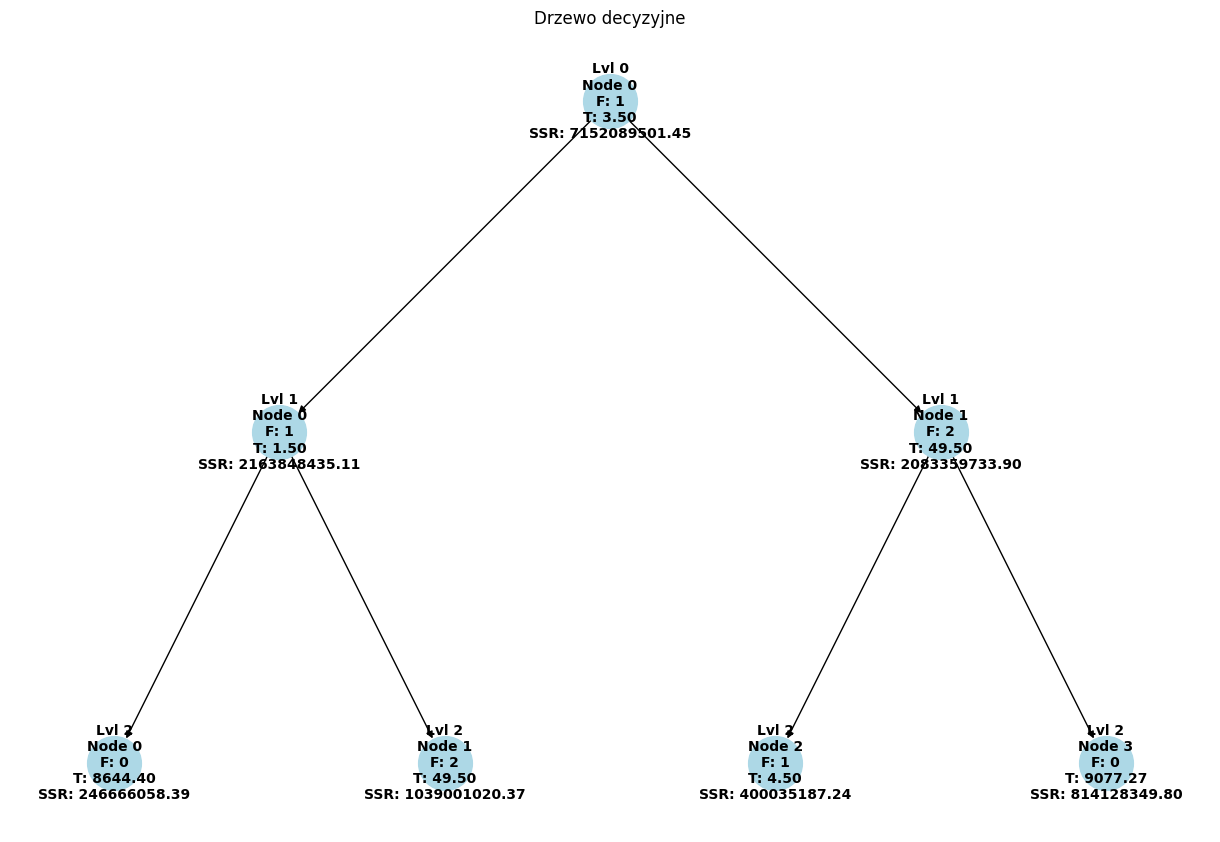

([[1], [1, 2], [0, 2, 1, 0]],
 [[np.float64(3.5)],
  [np.float64(1.5), np.float64(49.5)],
  [np.float64(8644.396889883832),
   np.float64(49.5),
   np.float64(4.5),
   np.float64(9077.266425312115)]])

In [24]:
X_train = df[["Income", "People", "Age"]].to_numpy()
y_train = df["Spending"].to_numpy()

features_per_level, thresholds_per_level, errors_per_level = fit_tree_SSR_min(X_train, y_train, max_depth, min_sample_split = 2)
visualize_tree_without_graphviz(features_per_level, thresholds_per_level, errors_per_level)

features_per_level, thresholds_per_level

### Minimalizacja przyrostu (II metdoa)

In [25]:
def Local_SSR_gain_min(X, y, min_sample_split):
    '''
    Ta funkcja działa na np arrays!
    '''
    # Walidacja wejść
    if X is None or y is None:
        return None, None, None
    if y.size == 0:
        return None, None, None

    num_of_features = X.shape[1]
    best_feature = None
    best_threshold = None
    best_gain =  - np.inf

    for feature in range(num_of_features):
        unique_values = np.unique(X[:, feature])
        # Jeśli cecha nie ma przynajmniej dwóch unikalnych wartości, podział nie ma sensu
        if unique_values.size < 2:
            continue
        values = np.sort(unique_values)
        
        # Jeśli liczba unikalnych wartości jest mniejsza niż wymagany próg, pomijamy tę cechę
        if values.size < min_sample_split:
            continue

        # Wyznaczamy potencjalne progi jako średnie kolejnych wartości
        thresholds = (values[:-1] + values[1:]) / 2

        for t in thresholds:
            mask = X[:, feature] <= t
            left_y = y[mask]
            right_y = y[~mask]
            
            # Możemy dodać warunek, by po podziale liczba próbek po stronie była większa lub równa min_sample_split
            if left_y.size < min_sample_split or right_y.size < min_sample_split:
                continue
            left_loss = SSR(left_y)
            right_loss = SSR(right_y)

            total_ssr = left_loss + right_loss
            all_ssr = SSR(y)
            ssr_gain = all_ssr - total_ssr

            # stosujemy pierwszą metodę związaną z minimalizacją błędu w danych "liściu", który dzielimy <- metoda I
            if ssr_gain > best_gain:
                best_gain = ssr_gain
                best_threshold = t
                best_feature = feature

    return best_feature, best_threshold, best_gain


#ta funkcja fituje drzewo danej głębokości

def fit_tree_SSR_gain_min(X_train, y_train, max_depth, min_sample_split):
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    thresholds_per_level = []
    features_per_level = []
    errors_per_level = []
    current_X_sets = [X_train]
    current_y_sets = [y_train]

    # przechodzimy przez kolejne warstwy

    for depth in range(max_depth):
        next_X_sets = []
        next_y_sets = []
        thresholds_level = []
        error_level = []
        features_level = []

        # dla poszczególnych zbiorów trenujemy nowe drzewo (mamy inny zbiór) i zapamiętujemy cechy, poziomy oraz błędy
        for X_subset, y_subset in zip(current_X_sets, current_y_sets):
            feature, threshold, err = Local_SSR_gain_min(X_subset, y_subset, min_sample_split)
            mask = X_subset[:, feature] <= threshold

            if feature is None:
                # Powtarzamy dane wejściowe jako "liść", żeby struktura się zgadzała
                thresholds_level.append(None)
                features_level.append(None)
                error_level.append(None)
                next_X_sets.extend([X_subset, X_subset])
                next_y_sets.extend([y_subset, y_subset])
                continue


            error_level.extend([err])
            next_X_sets.extend([X_subset[mask], X_subset[~mask]])
            next_y_sets.extend([y_subset[mask], y_subset[~mask]])
            
            
            thresholds_level.append(threshold)
            features_level.append(feature)

        current_X_sets = next_X_sets
        current_y_sets = next_y_sets
        thresholds_per_level.append(thresholds_level)
        features_per_level.append(features_level)
        errors_per_level.append(error_level)

    return features_per_level, thresholds_per_level, errors_per_level

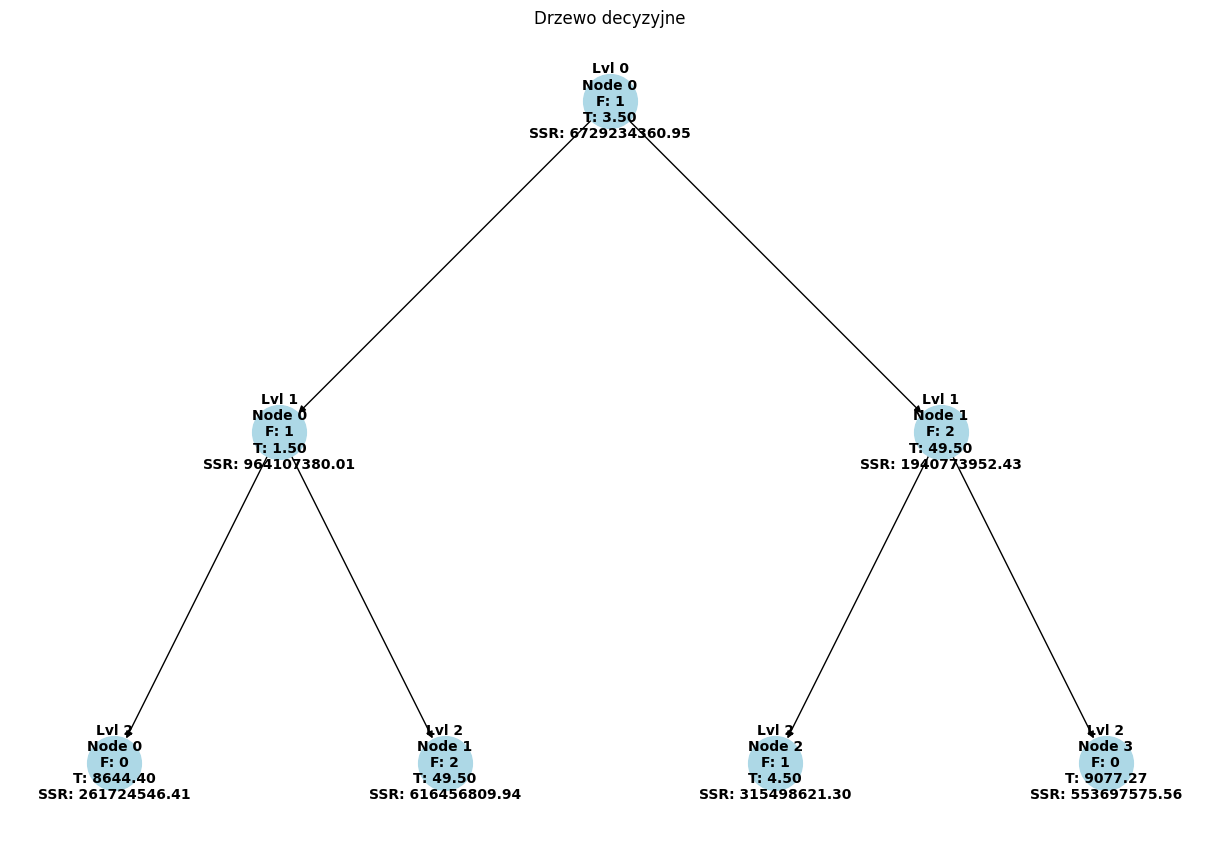

([[1], [1, 2], [0, 2, 1, 0]],
 [[np.float64(3.5)],
  [np.float64(1.5), np.float64(49.5)],
  [np.float64(8644.396889883832),
   np.float64(49.5),
   np.float64(4.5),
   np.float64(9077.266425312115)]])

In [26]:
X_train = df[["Income", "People", "Age"]].to_numpy()
y_train = df["Spending"].to_numpy()

features_per_level, thresholds_per_level, errors_per_level = fit_tree_SSR_gain_min(X_train, y_train, max_depth, min_sample_split=2)
visualize_tree_without_graphviz(features_per_level, thresholds_per_level, errors_per_level)
features_per_level, thresholds_per_level

### Minimalizajca sumarycznego błędu na wszystkich liściach (III metoda)

In [27]:
# Funkcja pomocnicza licząca łączny SSR dla listy liści
def helper_SSR(leaves):
    total_error = 0
    for leaf in leaves:
        if leaf is not None and leaf.size > 0:
            total_error += SSR(leaf)
    return total_error

# Funkcja wyznaczająca najlepszy podział dla podzbioru (X_train, y_train)
# Minimalizuje całkowity SSR na liściach przy dodaniu nowego podziału
def Total_SSR_min(X_train, y_train, leaves):
    """
    Funkcja działa na macierzach NumPy.
    Parametry:
      X_train, y_train - dane wejściowe (np. arrays)
      leaves - lista pozostałych liści, dla których liczymy SSR
    Zwraca:
      best_feature - indeks cechy użytej do podziału
      best_threshold - próg podziału
      best_ssr - łączny SSR po dodaniu nowych liści
    """
    # Weryfikacja wejścia
    if X_train is None or y_train is None or X_train.size == 0 or y_train.size == 0:
        return None, None, np.inf

    # Upewniamy się, że mamy numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    num_of_features = X_train.shape[1]
    best_feature = None
    best_threshold = None
    best_ssr = np.inf

    for feature in range(num_of_features):
        # Wyznaczenie uporządkowanych unikalnych wartości dla danej cechy
        values = np.sort(np.unique(X_train[:, feature]))
        # Jeśli cecha nie ma co najmniej dwóch unikalnych wartości, pomijamy ją
        if values.size < 2:
            continue

        # Wyznaczamy potencjalne progi jako średnie kolejnych wartości
        thresholds = (values[:-1] + values[1:]) / 2

        for t in thresholds:
            mask = X_train[:, feature] <= t
            left = y_train[mask]
            right = y_train[~mask]

            # Pomijamy próg, jeśli powoduje pusty podział
            if left.size == 0 or right.size == 0:
                continue

            total_ssr = helper_SSR(leaves + [left, right])

            if total_ssr < best_ssr:
                best_ssr = total_ssr
                best_threshold = t
                best_feature = feature

    return best_feature, best_threshold, best_ssr

# Funkcja budująca drzewo decyzyjne, które stara się minimalizować SSR na wszystkich liściach
def fit_Tree_Total_SSR(X_train, y_train, max_depth):
    """
    Buduje drzewo, przy czym każdy poziom drzewa poszukuje podziału, który
    minimalizuje sumaryczny SSR na liściach (tj. wszystkich podziałach aktualnego poziomu).
    Parametry:
      X_train, y_train - dane treningowe (np. arrays)
      max_depth - maksymalna głębokość drzewa
    Zwraca:
      features_per_level - lista funkcji użytych przy podziale na kolejnych poziomach
      thresholds_per_level - lista progów podziałów
      errors_per_level - lista SSR na poziomach
    """
    # Konwersja na numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    thresholds_per_level = []
    features_per_level = []
    errors_per_level = []
    current_X_sets = [X_train]
    current_y_sets = [y_train]

    for depth in range(max_depth):
        next_X_sets = []
        next_y_sets = []
        thresholds_level = []
        features_level = []
        error_level = []

        # Na bieżącym poziomie drzewa będziemy przeglądać każdą "łącznie" aktualną próbkę (leaf)
        for i, (X_subset, y_subset) in enumerate(zip(current_X_sets, current_y_sets)):
            # Tworzymy listę pozostałych liści (bez bieżącego)
            other_y_sets = [y for j, y in enumerate(current_y_sets) if j != i]

            # Pomijamy puste podzbiory
            if X_subset is None or X_subset.size == 0 or y_subset is None or y_subset.size == 0:
                thresholds_level.append(None)
                features_level.append(None)
                error_level.append(None)
                next_X_sets.extend([None, None])
                next_y_sets.extend([None, None])
                continue

            feature, threshold, err = Total_SSR_min(X_subset, y_subset, other_y_sets)

            # Jeśli nie znaleziono poprawnego podziału, zachowujemy bieżący liść bez zmian
            if feature is None or threshold is None:
                thresholds_level.append(None)
                features_level.append(None)
                error_level.append(None)
                next_X_sets.extend([None, None])
                next_y_sets.extend([None, None])
                continue

            # Ustalamy podział na podstawie wybranej cechy i progu
            mask = X_subset[:, feature] <= threshold
            left_X = X_subset[mask]
            left_y = y_subset[mask]
            right_X = X_subset[~mask]
            right_y = y_subset[~mask]

            thresholds_level.append(threshold)
            features_level.append(feature)
            error_level.append(err)

            next_X_sets.extend([left_X, right_X])
            next_y_sets.extend([left_y, right_y])

        current_X_sets = next_X_sets
        current_y_sets = next_y_sets
        thresholds_per_level.append(thresholds_level)
        features_per_level.append(features_level)
        errors_per_level.append(error_level)

    return features_per_level, thresholds_per_level, errors_per_level

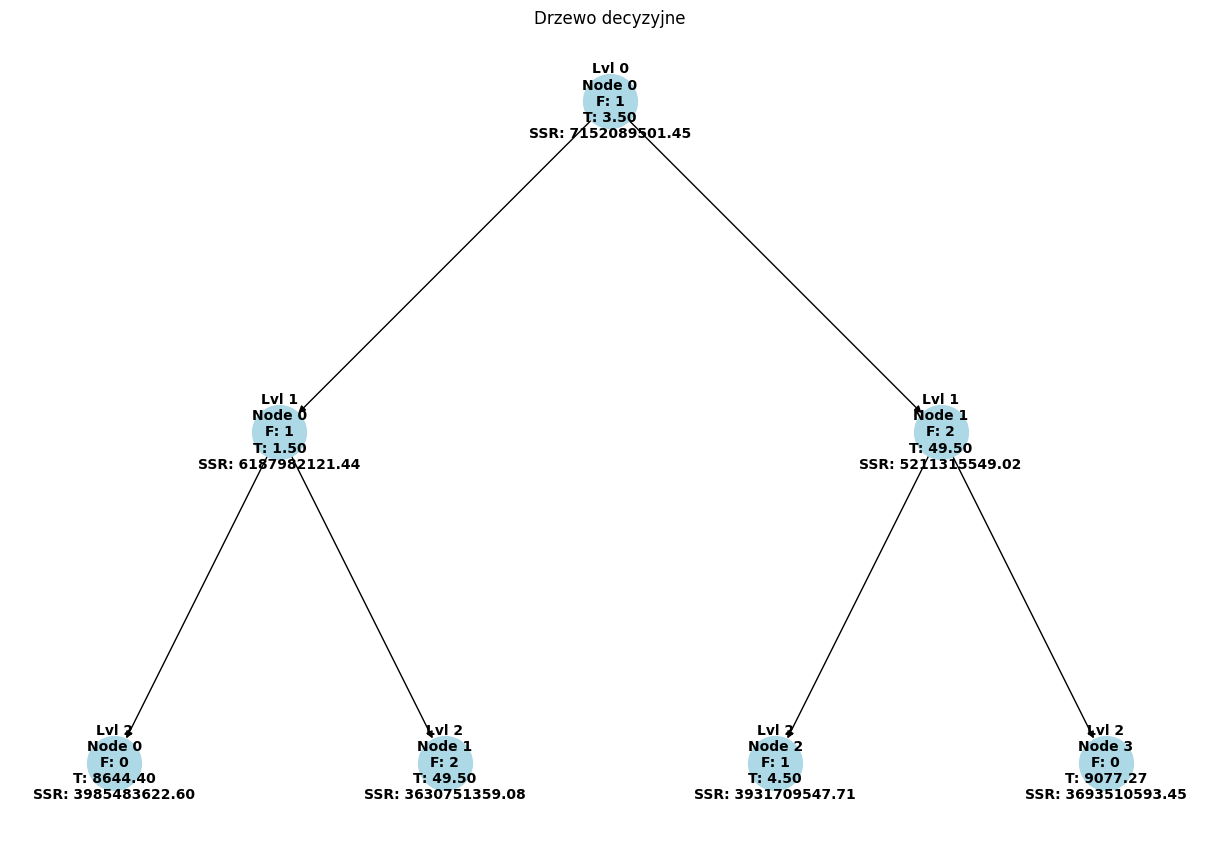

([[1], [1, 2], [0, 2, 1, 0]],
 [[np.float64(3.5)],
  [np.float64(1.5), np.float64(49.5)],
  [np.float64(8644.396889883832),
   np.float64(49.5),
   np.float64(4.5),
   np.float64(9077.266425312115)]])

In [28]:
X_train = df[["Income", "People", "Age"]].to_numpy()
y_train = df["Spending"].to_numpy()

features_per_level, thresholds_per_level, errors_per_level = fit_Tree_Total_SSR(X_train, y_train, max_depth)
visualize_tree_without_graphviz(features_per_level, thresholds_per_level, errors_per_level)
features_per_level, thresholds_per_level

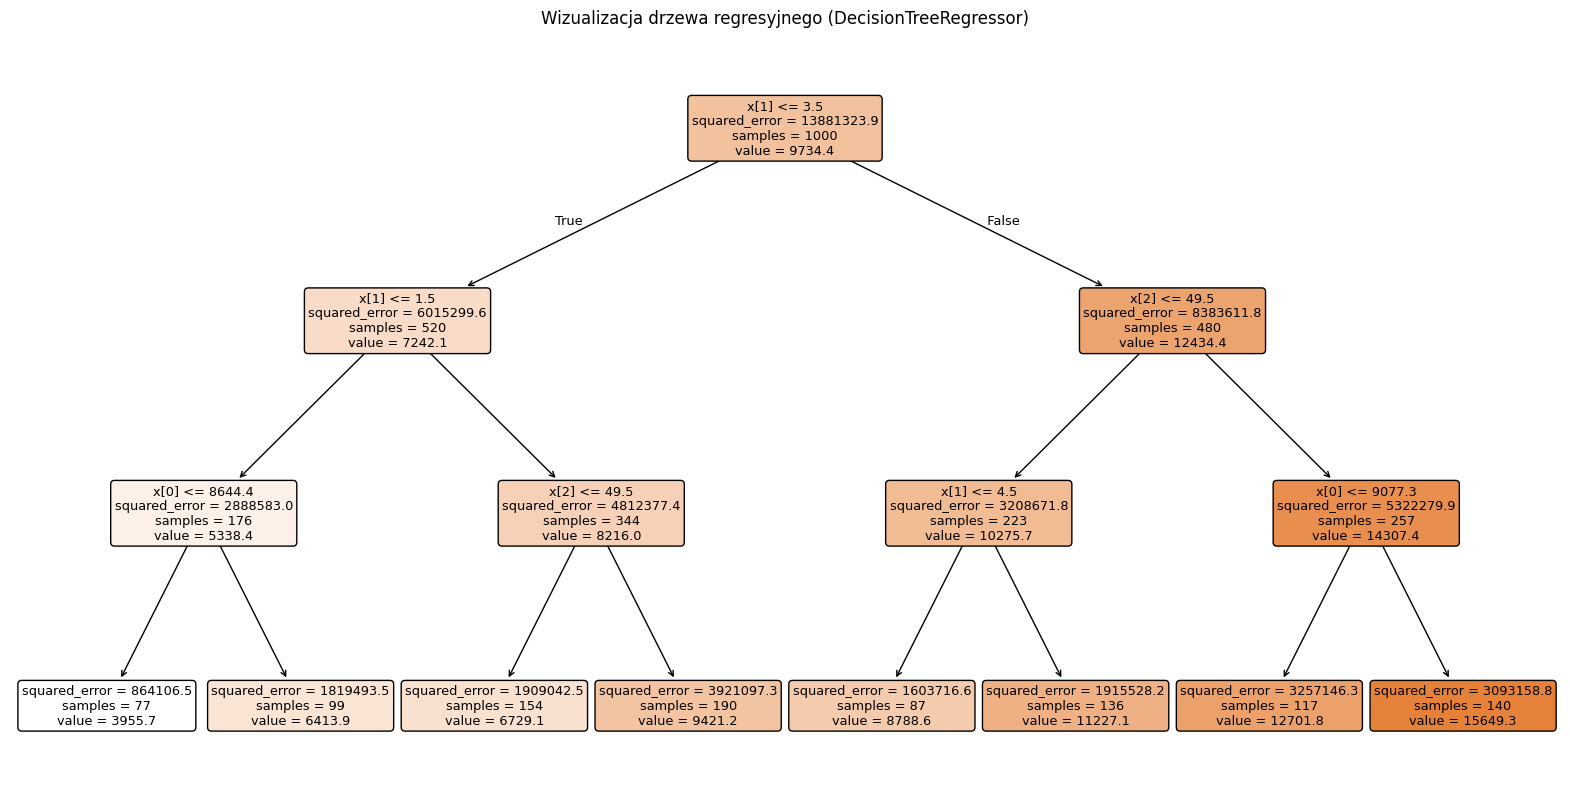

In [30]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Trenujemy model
model = DecisionTreeRegressor(max_depth=max_depth)
model.fit(X_train, y_train)

# Tworzymy wizualizację
plt.figure(figsize=(20, 10))  # Możesz zmienić wymiary dla większej liczby liści
plot_tree(
    model,
    filled=True,
    rounded=True,
    impurity=True,        # pokazuje błąd (SSR lub MSE w zależności od funkcji straty)
    precision=1
)
plt.title("Wizualizacja drzewa regresyjnego (DecisionTreeRegressor)")
plt.show()
